In [23]:
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import itertools
import os

sorted_aucs: {'intersect_f_Hindi': 0.8870328784771746, 'intersect_f_Norwegian': 0.9112115406406472, 'intersect_f_Italian': 0.9146460464995114, 'intersect_m_Norwegian': 0.9216770188491974, 'intersect_m_Hindi': 0.937931446216871, 'intersect_f_Spanish': 0.941109568817646, 'intersect_f_German': 0.9418680682445656, 'intersect_m_Spanish': 0.9503474976929334, 'intersect_f_English': 0.9556691423474832, 'intersect_f_Russian': 0.9608709362856622, 'intersect_f_Swedish': 0.9696205813162387, 'intersect_m_German': 0.9705241108056195, 'intersect_m_English': 0.9730689666428156, 'intersect_m_Italian': 0.980792131943163, 'intersect_f_Portuguese': 0.9877718590201615, 'intersect_m_Mixed': 0.9952130643594982}


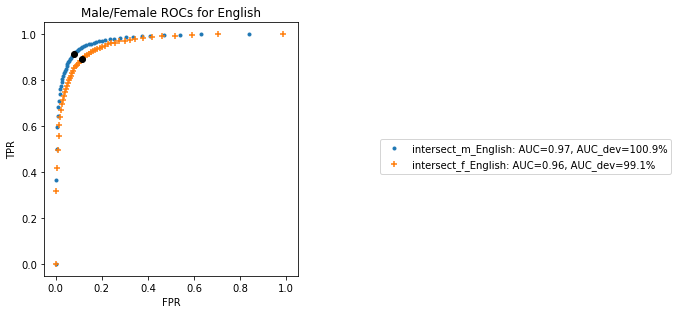

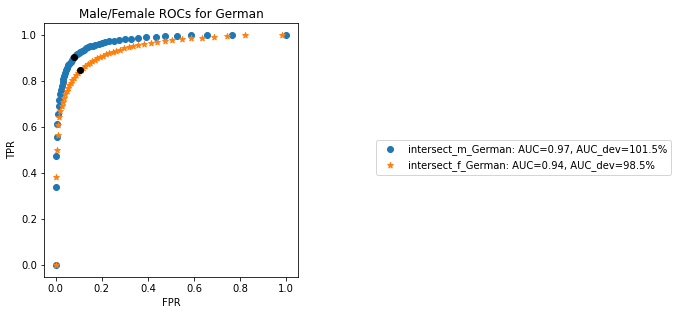

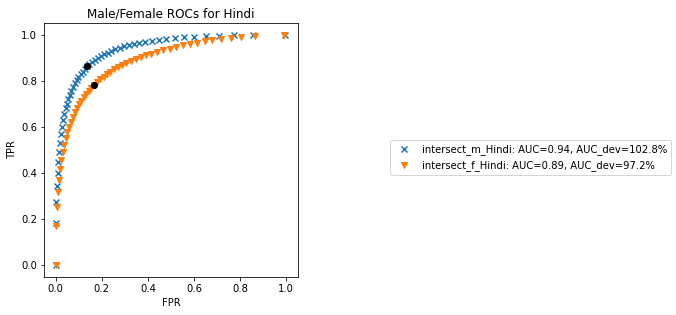

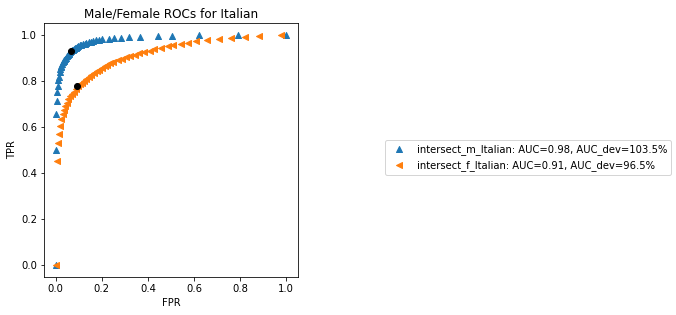

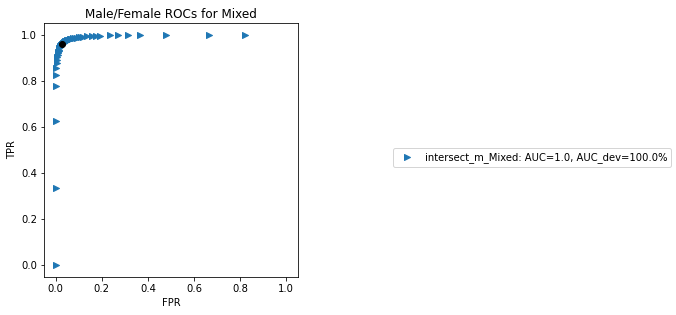

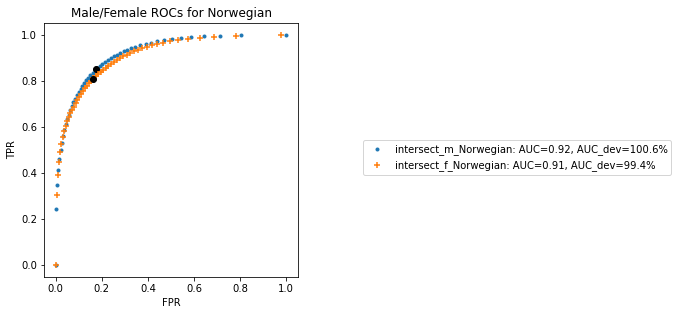

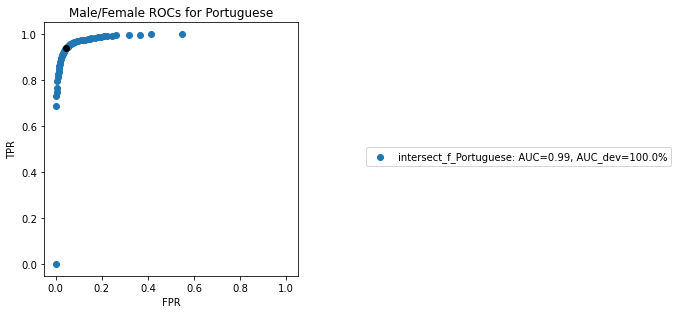

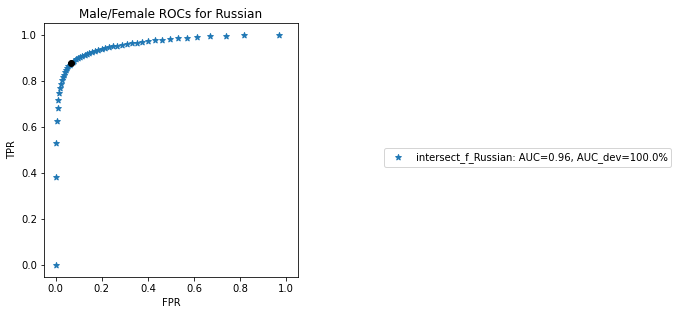

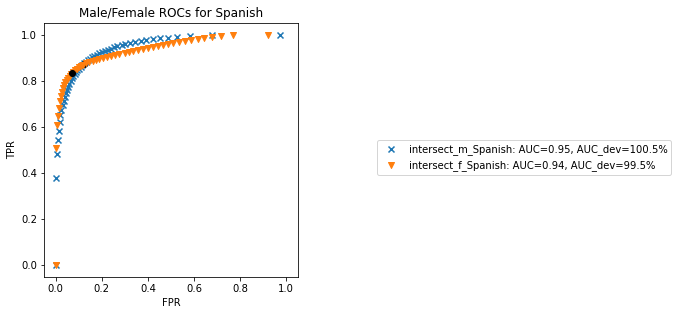

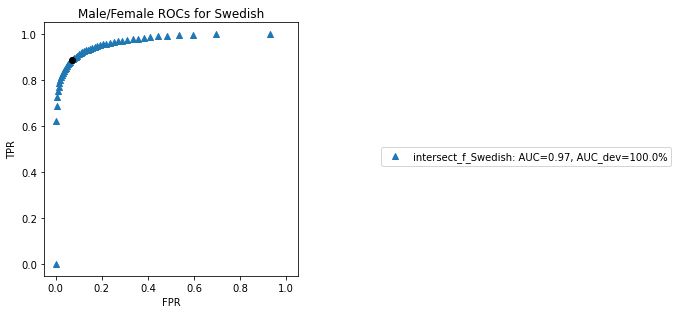

In [27]:
# @brief Return list of tuples of all combinations of keys in
#        the sensitive param provided as args
def get_intersection_combos(*sensitive_param_value_groups):
    return list(itertools.product(*sensitive_param_value_groups))

# @brief Convert intersection tuple to string
def id_to_str(id_tuple):
    return f"intersect_{'_'.join(id_tuple)}"

markers = itertools.cycle(('.', '+', 'o', '*', 'x', 'v', '^', '<', '>'))

    
def get_intersection_aucs(results, id_tuples):
    intersection_aucs = {}
    for id_tuple in id_tuples:
        name = id_to_str(id_tuple)
        
        try:
            fprs = results[f"{name}_fpr"]
            tprs = results[f"{name}_tpr"]
            intersection_aucs[name] = metrics.auc(fprs, tprs)
        except KeyError:
            pass
            
    return intersection_aucs

# @brief Plot roc curve from intersection names
def plot_roc(intersections_values):
    fig = plt.figure(figsize=(30,30))
    ax = fig.add_subplot(121)
    plt.rcParams.update({'font.size': 35})
    
    missing_intersections = []
    
    for intersection_values in intersections_values:
        intersection_name = f"intersect_{'_'.join(intersection_values)}"
        try:
            tpr = np.array(results[f"{intersection_name}_tpr"])
            fpr = np.array(results[f"{intersection_name}_fpr"])
            thresholds = np.array(results[f"{intersection_name}_thresholds"])
            best_equal_error = np.argmax(tpr - fpr)
            # plot roc
            n_plot_points = 30
            s = 350
            skip_interval = int(len(fpr)/n_plot_points)
            #print(f"skip_interval for {intersection_name} is {skip_interval}")
            ax.scatter(fpr[::skip_interval], tpr[::skip_interval],
                       label=intersection_name, marker=next(markers), s=s)
            # plot optimal point for equal error
            ax.scatter(fpr[best_equal_error], tpr[best_equal_error], marker='o',
                       color='black', s=s)
        except KeyError:
            missing_intersections.append(intersection_name)
        
    ax.set_aspect(1)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    fig.legend(loc='center right')
    plt.show()
    #print(f"Plotted intersections. Missing data for intersections: {missing_intersections}")
    
def get_roc_data_by_key(roc_data, key):
    try:
        tpr = np.array(results[f"{key}_tpr"])
        fpr = np.array(results[f"{key}_fpr"])
        thresholds = np.array(results[f"{key}_thresholds"])

        return True, [tpr, fpr, thresholds]
    except KeyError:
        return False, [None, None, None]

# @brief Add an ROC curve for sensitive param combination string `intersection_name`,
#        using data in `json_data`, to the pyplot `plt`
# @return AUC of the plotted ROC
def add_roc_to_plot(ax, tpr, fpr, thresholds, auc, auc_dev, name):
    best_equal_error = np.argmax(tpr - fpr)

    # plot roc
    n_plot_points = 50
    s = 350
    skip_interval = int(len(fpr)/n_plot_points)
    
    #auc = round(metrics.auc(fpr, tpr), 2)

    ax.scatter(fpr[::skip_interval], tpr[::skip_interval],
               label=f"{name}: AUC={round(auc,2)}, AUC_dev={round(auc_dev*100,1)}%",
               marker=next(markers))#, s=s)
    # plot optimal point for equal error
    ax.scatter(fpr[best_equal_error], tpr[best_equal_error], marker='o',
               color='black')#, s=s)

# @brief Plot roc curve from intersection names
def plot_roc_by_gender(results, intersections_values, save_path):
    intersections_values = sorted(intersections_values, key=lambda x: x[1])
    
    # add male/female pairs to plots
    for i in range(0, len(intersections_values), 2):
        all_plot_metrics = {}
        auc_sum = 0

        # get roc data from json dict and queue metrics to plot
        keys = intersections_values[i:i+2]

        # queue male and female metrics for plotting
        for key in keys:
            intersection_name = f"intersect_{'_'.join(key)}"
            exists, series_plot_metrics = get_roc_data_by_key(results, intersection_name)
            if exists:
                auc = metrics.auc(series_plot_metrics[1], series_plot_metrics[0])
                all_plot_metrics[intersection_name] = [*series_plot_metrics, auc]
                auc_sum += auc
                
        # add difference from avg AUC for each ROC to plot                
        if len(all_plot_metrics) > 0:
            auc_avg = auc_sum / len(all_plot_metrics)
            for key in all_plot_metrics.keys():
                # append deviation from average
                _, _, _, auc = all_plot_metrics[key]
                all_plot_metrics[key] = [*all_plot_metrics[key], auc / auc_avg]
        
        if len(all_plot_metrics) > 0:
            #print(f"plotmetrics contains {len(all_plot_metrics)}")
            fig = plt.figure(figsize=(10,10))
            ax = fig.add_subplot(121)
            aucs = []
        
            for i, (key, series_plot_metrics) in enumerate(all_plot_metrics.items()):
                aucs.append(add_roc_to_plot(ax, *series_plot_metrics, key))
                
            plt_name = f"Male/Female ROCs for {keys[0][1]}"
            plt.title(plt_name)
            plt.xlim((-.05, 1.05))
        
            ax.set_aspect(1)
            ax.set_xlabel("FPR")
            ax.set_ylabel("TPR")
            fig.legend(loc='center right')
            
            save_name = plt_name.replace('/','_').replace(' ', '_')
            plt.savefig(os.path.join(save_path, save_name))
            plt.show()

# ROC plot save path
roc_plt_save_path = "/home/jupyter/voxceleb-fairness/data/roc/plots/per-native-lang/"
            
# all sensitive param values
gender_values = ['m', 'f']
native_lang_map_full = {'Australia': 'English', 'India': 'Hindi', 'Norway': 'Norwegian', 'Ireland': 'English', 'Germany': 'German', 'New Zealand': 'English', 'Italy': 'Italian','Mexico': 'Spanish',\
                  'Sweden': 'Swedish', 'Spain': 'Spanish', 'Russia': 'Russian', 'Switzerland': 'Mixed', 'Chile': 'Spanish', 'Philippines': 'English', 'Croatia': 'Croatian', 'Denmark': 'Danish',\
                  'Netherlands': 'Dutch', 'Poland': 'Polish', 'Portugal': 'Portuguese', 'China': 'Mandarin', 'France': 'French', 'Guyana': 'English', 'Singapore': 'English', 'Brazil': 'Portuguese',\
                  'Sri Lanka': 'Sinhala', 'South Africa': 'Afrikaans', 'South Korea': 'Korean', 'Trinidad and Tobago': 'English', 'Pakistan': 'English', 'Austria': 'German',\
                  'Israel': 'Hebrew', 'Iran': 'Persian', 'Sudan': 'Arabic', 'USA': 'English', 'UK': 'English', 'Canada': 'English'}
native_lang_values_full = list(set(native_lang_map_full.values()))

gender_native_lang_full_intersections = get_intersection_combos(gender_values, native_lang_values_full)

with open('/home/jupyter/voxceleb-fairness/data/roc/roc_intersect_gender_native_lang_full.json', 'r') as fp:
    results = json.load(fp)
    
    # compute AUCs
    intersection_aucs = get_intersection_aucs(results, gender_native_lang_full_intersections)
    sorted_aucs = {k: v for k, v in sorted(intersection_aucs.items(), key=lambda item: item[1])}
    print(f"sorted_aucs: {sorted_aucs}")
    
    # plot Gender / Native-Lang intersection ROC
    #print(gender_native_lang_full_intersections)
    plot_roc_by_gender(results, gender_native_lang_full_intersections, roc_plt_save_path)


In [25]:
female_thresholds[best_female]

NameError: name 'female_thresholds' is not defined

In [ ]:
male_thresholds[best_male]

In [ ]:
corres_f_idx = female_thresholds.size - np.searchsorted(female_thresholds[::-1], male_thresholds[best_male], side="right")

In [ ]:
female_thresholds

In [ ]:
female_fpr[best_female], female_tpr[best_female]

In [ ]:
female_fpr[corres_f_idx], female_tpr[corres_f_idx]

In [ ]:
corres_m_idx = male_thresholds.size - np.searchsorted(male_thresholds[::-1], female_thresholds[best_female], side="right")

In [ ]:
male_fpr[best_male], male_tpr[best_male]

In [ ]:
male_fpr[corres_m_idx], male_tpr[corres_m_idx]

In [ ]:
metrics.auc(male_fpr, male_tpr)

In [ ]:
metrics.auc(female_fpr, female_tpr)